In [1]:
import gym
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf

In [2]:
from collections import deque
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
tf.version

<module 'tensorflow._api.v2.version' from '/Users/kavlraghu/opt/anaconda3/lib/python3.8/site-packages/tensorflow/_api/v2/version/__init__.py'>

In [4]:
env = gym.make('CartPole-v1')

In [35]:
BATCH_SIZE=32
GAMMA=0.98
LEARNING_RATE=0.005
UPDATE_TARGET_WEIGHTS_AFTER=30
REPLAY_MEMORY_SIZE=50000
TOTAL_EPISODES =5000 

In [6]:
total_actions = env.action_space.n
input_size = len(env.observation_space.sample())

In [7]:
class Replay_Memory():
    def __init__(self):
        self.buffer = deque(maxlen=REPLAY_MEMORY_SIZE)
        
    def add_transition(self,transition):
        self.buffer.append(transition)
        
    def sample(self):
        batch_size = min(BATCH_SIZE, len(self.buffer))
        batch = random.sample(self.buffer,batch_size)
        state_list,action_list,reward_list,next_state_list,done_list = [],[],[],[],[]
        for transition in batch:
            state_list.append(transition[0])
            action_list.append(transition[1])
            reward_list.append(transition[2])
            next_state_list.append(transition[3])
            done_list.append(transition[4])
        return np.array(state_list),action_list,reward_list,np.array(next_state_list),done_list
    
    def size(self):
        return len(self.buffer)

In [8]:
def make_NN_network(input_size,total_actions):
    model = Sequential()
    model.add(Dense(64,input_dim=input_size,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(total_actions,activation='linear'))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
    return model

In [9]:
class DQN_Agent():
    def __init__(self):
        self.q_net = make_NN_network(input_size,total_actions)
        self.target_net = make_NN_network(input_size,total_actions)
    
    def chose_action(self,state,epsilon):
        if np.random.random()>epsilon:
            state_tensor = tf.convert_to_tensor(state[None,:])
            action_tensor = self.q_net(state_tensor)
            action = np.argmax(action_tensor.numpy()[0],axis=0)
            return action
        else:
            return np.random.randint(0,total_actions)
        
        
    def train(self,mini_batch):
        state_batch, action_batch, reward_batch, next_state_batch,done_batch = mini_batch
        q_current_state = self.q_net(state_batch)
        q_val_target = np.copy(q_current_state)
        q_next_state = self.target_net(next_state_batch)
        q_next_state_max = np.max(q_next_state,axis=1)
        for i in range(state_batch.shape[0]):
            q_val_target[i][action_batch[i]] = reward_batch[i]
            if not done_batch:
                q_val_target[i][action_batch[i]] += GAMMA*q_next_state_max
        model_fit = self.q_net.fit(state_batch,q_val_target)
        return model_fit.history['loss']
    
    def update_target_network_weights(self):
         self.target_net.set_weights(self.q_net.get_weights ())

### Model Training

In [36]:
agent = DQN_Agent()
memory = Replay_Memory()
score_list = []
score = 0
for n_ep in range(TOTAL_EPISODES):
    epsilon = max(0.01,0.08-0.01*(n_ep/200))
    curr_state = env.reset()
    done=False
    while not done:
        action = agent.chose_action(curr_state,epsilon)
        next_state,reward,done,_=env.step(action)
        score+=reward
        memory.add_transition((curr_state,action,reward,next_state,done))
        curr_state = next_state
    score_list.append(score)
    sample_batch = memory.sample()
    loss = agent.train(sample_batch)
    if n_ep%UPDATE_TARGET_WEIGHTS_AFTER == 0:
        agent.update_target_network_weights()
        print('num_eps: {} loss: {} score: {}'.format(n_ep,loss,score/UPDATE_TARGET_WEIGHTS_AFTER))
        score=0
env.close()

1/1 [==============================] - 0s 312ms/step - loss: 0.1548
num_eps: 0 loss: [0.15475869178771973] score: 0.3333333333333333
1/1 [==============================] - 0s 6ms/step - loss: 0.0041
num_eps: 30 loss: [0.0040777139365673065] score: 11.533333333333333
1/1 [==============================] - 0s 5ms/step - loss: 5.2438e-04
num_eps: 60 loss: [0.000524383969604969] score: 11.866666666666667
1/1 [==============================] - 0s 3ms/step - loss: 9.1126e-04
num_eps: 90 loss: [0.0009112623520195484] score: 12.966666666666667
1/1 [==============================] - 0s 3ms/step - loss: 4.7055e-04


1/1 [==============================] - 0s 4ms/step - loss: 4.4378e-04
num_eps: 120 loss: [0.0004437793977558613] score: 17.266666666666666
1/1 [==============================] - 0s 3ms/step - loss: 1.0178e-04
num_eps: 150 loss: [0.00010178027878282592] score: 13.7
1/1 [==============================] - 0s 3ms/step - loss: 2.6130e-05
num_eps: 180 loss: [2.613026663311757e-05] score: 17.266666666666666
1/1 [==============================] - 0s 3ms/step - loss: 6.0187e-05
num_eps: 210 loss: [6.01866195211187e-05] score: 21.2
1/1 [==============================] - 0s 4ms/step - loss: 2.4607e-05


1/1 [==============================] - 0s 3ms/step - loss: 2.0104e-05
num_eps: 240 loss: [2.0103794668102637e-05] score: 22.9
1/1 [==============================] - 0s 3ms/step - loss: 2.2314e-05
num_eps: 270 loss: [2.231376856798306e-05] score: 20.166666666666668
1/1 [==============================] - 0s 3ms/step - loss: 2.4239e-05
num_eps: 300 loss: [2.423895784886554e-05] score: 20.033333333333335
1/1 [==============================] - 0s 3ms/step - loss: 1.5499e-05
num_eps: 330 loss: [1.5498917491640896e-05] score: 20.8
1/1 [==============================] - 0s 3ms/step - loss: 2.6599e-05


1/1 [==============================] - 0s 4ms/step - loss: 4.5029e-05
num_eps: 360 loss: [4.502874435274862e-05] score: 16.0
1/1 [==============================] - 0s 3ms/step - loss: 1.8601e-05
num_eps: 390 loss: [1.8601267584017478e-05] score: 15.466666666666667
1/1 [==============================] - 0s 4ms/step - loss: 1.2814e-05
num_eps: 420 loss: [1.2813636203645729e-05] score: 17.4
1/1 [==============================] - 0s 3ms/step - loss: 1.0832e-05
num_eps: 450 loss: [1.0831839063030202e-05] score: 22.733333333333334
1/1 [==============================] - 0s 3ms/step - loss: 6.9381e-06


1/1 [==============================] - 0s 3ms/step - loss: 9.2896e-06
num_eps: 480 loss: [9.289644367527217e-06] score: 17.5
1/1 [==============================] - 0s 4ms/step - loss: 4.4562e-06
num_eps: 510 loss: [4.4561511458596215e-06] score: 19.233333333333334
1/1 [==============================] - 0s 3ms/step - loss: 1.1901e-05
num_eps: 540 loss: [1.1901004654646385e-05] score: 18.366666666666667
1/1 [==============================] - 0s 4ms/step - loss: 1.0745e-04


1/1 [==============================] - 0s 4ms/step - loss: 6.3530e-05
num_eps: 570 loss: [6.35300821159035e-05] score: 14.233333333333333
1/1 [==============================] - 0s 4ms/step - loss: 8.6401e-05
num_eps: 600 loss: [8.640145824756473e-05] score: 17.033333333333335
1/1 [==============================] - 0s 3ms/step - loss: 2.7424e-04
num_eps: 630 loss: [0.0002742377982940525] score: 17.066666666666666
1/1 [==============================] - 0s 4ms/step - loss: 7.7964e-05
num_eps: 660 loss: [7.796350109856576e-05] score: 22.933333333333334
1/1 [==============================] - 0s 3ms/step - loss: 3.5093e-05


1/1 [==============================] - 0s 3ms/step - loss: 2.0308e-05
num_eps: 690 loss: [2.0308338207541965e-05] score: 22.366666666666667
1/1 [==============================] - 0s 3ms/step - loss: 2.1704e-05
num_eps: 720 loss: [2.170404331991449e-05] score: 16.833333333333332
1/1 [==============================] - 0s 5ms/step - loss: 2.2752e-05
num_eps: 750 loss: [2.2752237782697193e-05] score: 22.0
1/1 [==============================] - 0s 3ms/step - loss: 3.4796e-05
num_eps: 780 loss: [3.479623410385102e-05] score: 35.03333333333333
1/1 [==============================] - 0s 3ms/step - loss: 2.2670e-05


1/1 [==============================] - 0s 3ms/step - loss: 6.0036e-06
num_eps: 810 loss: [6.003563157719327e-06] score: 21.633333333333333
1/1 [==============================] - 0s 3ms/step - loss: 2.5785e-05
num_eps: 840 loss: [2.5785226171137765e-05] score: 30.733333333333334
1/1 [==============================] - 0s 4ms/step - loss: 4.0665e-05
num_eps: 870 loss: [4.066464680363424e-05] score: 20.9
1/1 [==============================] - 0s 3ms/step - loss: 2.5874e-05
num_eps: 900 loss: [2.587410381238442e-05] score: 26.0
1/1 [==============================] - 0s 3ms/step - loss: 1.7281e-05


1/1 [==============================] - 0s 5ms/step - loss: 5.9516e-05
num_eps: 930 loss: [5.951607454335317e-05] score: 17.333333333333332
1/1 [==============================] - 0s 4ms/step - loss: 1.2643e-05
num_eps: 960 loss: [1.2643258742173202e-05] score: 34.63333333333333
1/1 [==============================] - 0s 3ms/step - loss: 5.3021e-06
num_eps: 990 loss: [5.302125828166027e-06] score: 26.1
1/1 [==============================] - 0s 4ms/step - loss: 9.8910e-05
num_eps: 1020 loss: [9.891000809147954e-05] score: 38.833333333333336


1/1 [==============================] - 0s 21ms/step - loss: 3.1191e-04
num_eps: 1050 loss: [0.00031191337620839477] score: 13.6
1/1 [==============================] - 0s 6ms/step - loss: 8.6796e-05
num_eps: 1080 loss: [8.679642633069307e-05] score: 20.366666666666667
1/1 [==============================] - 0s 16ms/step - loss: 9.5806e-05
num_eps: 1110 loss: [9.580550249665976e-05] score: 29.233333333333334
1/1 [==============================] - 0s 11ms/step - loss: 3.8111e-05


1/1 [==============================] - 0s 3ms/step - loss: 4.9492e-05
num_eps: 1140 loss: [4.9491674872115254e-05] score: 43.43333333333333
1/1 [==============================] - 0s 3ms/step - loss: 1.5035e-05
num_eps: 1170 loss: [1.5034831449156627e-05] score: 23.866666666666667
1/1 [==============================] - 0s 4ms/step - loss: 5.4031e-06
num_eps: 1200 loss: [5.40311475560884e-06] score: 30.233333333333334
1/1 [==============================] - 0s 3ms/step - loss: 1.9679e-05
num_eps: 1230 loss: [1.9678693206515163e-05] score: 26.2
1/1 [==============================] - 0s 4ms/step - loss: 3.4410e-06


1/1 [==============================] - 0s 3ms/step - loss: 9.5250e-06
num_eps: 1260 loss: [9.525032510282472e-06] score: 31.166666666666668
1/1 [==============================] - 0s 3ms/step - loss: 4.7821e-06
num_eps: 1290 loss: [4.782094947586302e-06] score: 25.733333333333334
1/1 [==============================] - 0s 3ms/step - loss: 1.2526e-05
num_eps: 1320 loss: [1.2526407772384118e-05] score: 17.7
1/1 [==============================] - 0s 3ms/step - loss: 1.5397e-05
num_eps: 1350 loss: [1.53971432155231e-05] score: 11.7
1/1 [==============================] - 0s 5ms/step - loss: 2.4647e-06


1/1 [==============================] - 0s 4ms/step - loss: 1.2279e-05
num_eps: 1380 loss: [1.2279462680453435e-05] score: 24.5
1/1 [==============================] - 0s 3ms/step - loss: 3.6189e-06
num_eps: 1410 loss: [3.618918071879307e-06] score: 15.4
1/1 [==============================] - 0s 4ms/step - loss: 5.4317e-05
num_eps: 1440 loss: [5.431655881693587e-05] score: 27.666666666666668
1/1 [==============================] - 0s 3ms/step - loss: 6.7195e-05
num_eps: 1470 loss: [6.719469820382074e-05] score: 14.966666666666667
1/1 [==============================] - 0s 4ms/step - loss: 4.6914e-05


1/1 [==============================] - 0s 4ms/step - loss: 8.2686e-05
num_eps: 1500 loss: [8.268555393442512e-05] score: 15.033333333333333
1/1 [==============================] - 0s 3ms/step - loss: 7.0558e-05
num_eps: 1530 loss: [7.05578422639519e-05] score: 11.233333333333333
1/1 [==============================] - 0s 3ms/step - loss: 4.6110e-05
num_eps: 1560 loss: [4.6110239054542035e-05] score: 36.13333333333333
1/1 [==============================] - 0s 4ms/step - loss: 6.9247e-06


1/1 [==============================] - 0s 3ms/step - loss: 4.1477e-05
num_eps: 1590 loss: [4.147741128690541e-05] score: 14.866666666666667
1/1 [==============================] - 0s 3ms/step - loss: 1.1773e-04
num_eps: 1620 loss: [0.00011772973084589466] score: 15.366666666666667
1/1 [==============================] - 0s 3ms/step - loss: 2.3274e-05
num_eps: 1650 loss: [2.3273862097994424e-05] score: 18.866666666666667
1/1 [==============================] - 0s 3ms/step - loss: 1.1024e-05
num_eps: 1680 loss: [1.102438909583725e-05] score: 22.533333333333335
1/1 [==============================] - 0s 3ms/step - loss: 1.2369e-05


1/1 [==============================] - 0s 3ms/step - loss: 1.6286e-05
num_eps: 1710 loss: [1.62864107551286e-05] score: 23.833333333333332
1/1 [==============================] - 0s 3ms/step - loss: 4.7650e-06
num_eps: 1740 loss: [4.765005996887339e-06] score: 17.133333333333333
1/1 [==============================] - 0s 3ms/step - loss: 1.2319e-05
num_eps: 1770 loss: [1.2319389497861266e-05] score: 36.4
1/1 [==============================] - 0s 3ms/step - loss: 1.5658e-05
num_eps: 1800 loss: [1.5658104530302808e-05] score: 14.766666666666667
1/1 [==============================] - 0s 4ms/step - loss: 0.0017


1/1 [==============================] - 0s 4ms/step - loss: 2.5807e-04
num_eps: 1830 loss: [0.00025806957273744047] score: 16.9
1/1 [==============================] - 0s 3ms/step - loss: 6.6207e-04
num_eps: 1860 loss: [0.000662072270642966] score: 13.833333333333334
1/1 [==============================] - 0s 4ms/step - loss: 6.9367e-05
num_eps: 1890 loss: [6.936728459550068e-05] score: 24.3
1/1 [==============================] - 0s 3ms/step - loss: 4.3100e-05
num_eps: 1920 loss: [4.309984797146171e-05] score: 29.266666666666666
1/1 [==============================] - 0s 5ms/step - loss: 1.7374e-05


1/1 [==============================] - 0s 3ms/step - loss: 2.0238e-05
num_eps: 1950 loss: [2.0237679564161226e-05] score: 16.733333333333334
1/1 [==============================] - 0s 5ms/step - loss: 4.9799e-05
num_eps: 1980 loss: [4.979912773706019e-05] score: 15.566666666666666
1/1 [==============================] - 0s 3ms/step - loss: 7.0298e-05
num_eps: 2010 loss: [7.029808330116794e-05] score: 22.8
1/1 [==============================] - 0s 5ms/step - loss: 5.4411e-06


1/1 [==============================] - 0s 5ms/step - loss: 5.5295e-06
num_eps: 2040 loss: [5.529547706828453e-06] score: 22.666666666666668
1/1 [==============================] - 0s 3ms/step - loss: 8.6930e-06
num_eps: 2070 loss: [8.693037671037018e-06] score: 18.7
1/1 [==============================] - 0s 4ms/step - loss: 1.3734e-05
num_eps: 2100 loss: [1.37341821755399e-05] score: 20.9
1/1 [==============================] - 0s 4ms/step - loss: 3.1914e-06
num_eps: 2130 loss: [3.1913709790387657e-06] score: 27.266666666666666
1/1 [==============================] - 0s 8ms/step - loss: 5.8467e-06


1/1 [==============================] - 0s 5ms/step - loss: 7.2203e-06
num_eps: 2160 loss: [7.220276984298835e-06] score: 18.3
1/1 [==============================] - 0s 4ms/step - loss: 3.7766e-06
num_eps: 2190 loss: [3.7766494642710313e-06] score: 12.666666666666666
1/1 [==============================] - 0s 5ms/step - loss: 4.3837e-06
num_eps: 2220 loss: [4.383700343169039e-06] score: 18.633333333333333
1/1 [==============================] - 0s 4ms/step - loss: 4.8167e-06
num_eps: 2250 loss: [4.816729415324517e-06] score: 20.8
1/1 [==============================] - 0s 3ms/step - loss: 3.4442e-06


1/1 [==============================] - 0s 4ms/step - loss: 1.3892e-06
num_eps: 2280 loss: [1.389201202073309e-06] score: 24.233333333333334
1/1 [==============================] - 0s 3ms/step - loss: 5.3250e-06
num_eps: 2310 loss: [5.324953235685825e-06] score: 18.066666666666666
1/1 [==============================] - 0s 3ms/step - loss: 1.6400e-05
num_eps: 2340 loss: [1.6400153981521726e-05] score: 20.7
1/1 [==============================] - 0s 3ms/step - loss: 1.6776e-05
num_eps: 2370 loss: [1.6775533367763273e-05] score: 15.2
1/1 [==============================] - 0s 3ms/step - loss: 1.9698e-06


1/1 [==============================] - 0s 3ms/step - loss: 1.9115e-06
num_eps: 2400 loss: [1.91152957995655e-06] score: 23.766666666666666
1/1 [==============================] - 0s 8ms/step - loss: 1.3385e-05
num_eps: 2430 loss: [1.3385115380515344e-05] score: 16.4
1/1 [==============================] - 0s 3ms/step - loss: 1.7227e-05
num_eps: 2460 loss: [1.722669549053535e-05] score: 15.866666666666667
1/1 [==============================] - 0s 3ms/step - loss: 1.0936e-05
num_eps: 2490 loss: [1.0935883437923621e-05] score: 13.266666666666667


1/1 [==============================] - 0s 4ms/step - loss: 1.7877e-06
num_eps: 2520 loss: [1.7877072195915389e-06] score: 22.4
1/1 [==============================] - 0s 4ms/step - loss: 7.2458e-06
num_eps: 2550 loss: [7.245800588862039e-06] score: 12.2
1/1 [==============================] - 0s 3ms/step - loss: 6.1460e-06
num_eps: 2580 loss: [6.146021405584179e-06] score: 12.5
1/1 [==============================] - 0s 5ms/step - loss: 3.7553e-06


1/1 [==============================] - 0s 3ms/step - loss: 2.3985e-06
num_eps: 2610 loss: [2.3985430743778124e-06] score: 21.6
1/1 [==============================] - 0s 3ms/step - loss: 1.4465e-06
num_eps: 2640 loss: [1.4465497315541143e-06] score: 21.6
1/1 [==============================] - 0s 13ms/step - loss: 4.0946e-06
num_eps: 2670 loss: [4.0945706132333726e-06] score: 40.1
1/1 [==============================] - 0s 3ms/step - loss: 2.1429e-06
num_eps: 2700 loss: [2.142901848856127e-06] score: 15.133333333333333
1/1 [==============================] - 0s 3ms/step - loss: 6.1965e-06


1/1 [==============================] - 0s 3ms/step - loss: 1.3915e-05
num_eps: 2730 loss: [1.3915479939896613e-05] score: 25.566666666666666
1/1 [==============================] - 0s 138ms/step - loss: 8.2693e-06
num_eps: 2760 loss: [8.269322279375046e-06] score: 16.866666666666667
1/1 [==============================] - 0s 4ms/step - loss: 4.9407e-06
num_eps: 2790 loss: [4.94072082801722e-06] score: 14.7
1/1 [==============================] - 0s 3ms/step - loss: 6.1323e-06
num_eps: 2820 loss: [6.132274393166881e-06] score: 16.7
1/1 [==============================] - 0s 3ms/step - loss: 1.5661e-06


1/1 [==============================] - 0s 3ms/step - loss: 6.3936e-06
num_eps: 2850 loss: [6.393645435309736e-06] score: 14.433333333333334
1/1 [==============================] - 0s 3ms/step - loss: 6.1880e-06
num_eps: 2880 loss: [6.188049155753106e-06] score: 15.766666666666667
1/1 [==============================] - 0s 4ms/step - loss: 5.3095e-06
num_eps: 2910 loss: [5.309533662511967e-06] score: 12.0
1/1 [==============================] - 0s 4ms/step - loss: 1.6966e-05
num_eps: 2940 loss: [1.696619983704295e-05] score: 19.1
1/1 [==============================] - 0s 3ms/step - loss: 4.5443e-06


1/1 [==============================] - 0s 3ms/step - loss: 7.6660e-05
num_eps: 2970 loss: [7.666019519092515e-05] score: 13.933333333333334
1/1 [==============================] - 0s 3ms/step - loss: 9.4894e-06
num_eps: 3000 loss: [9.489449439570308e-06] score: 17.6
1/1 [==============================] - 0s 3ms/step - loss: 1.0135e-05
num_eps: 3030 loss: [1.0135461707250215e-05] score: 17.266666666666666
1/1 [==============================] - 0s 3ms/step - loss: 2.5063e-06


1/1 [==============================] - 0s 3ms/step - loss: 7.1781e-06
num_eps: 3060 loss: [7.17806051397929e-06] score: 10.233333333333333
1/1 [==============================] - 0s 4ms/step - loss: 7.7275e-06
num_eps: 3090 loss: [7.72749899624614e-06] score: 21.5
1/1 [==============================] - 0s 3ms/step - loss: 2.0733e-05
num_eps: 3120 loss: [2.073347604891751e-05] score: 12.5
1/1 [==============================] - 0s 3ms/step - loss: 8.1098e-06
num_eps: 3150 loss: [8.109804184641689e-06] score: 15.566666666666666
1/1 [==============================] - 0s 3ms/step - loss: 5.2096e-06


1/1 [==============================] - 0s 3ms/step - loss: 1.8742e-06
num_eps: 3180 loss: [1.8741891381068854e-06] score: 13.733333333333333
1/1 [==============================] - 0s 3ms/step - loss: 9.3705e-06
num_eps: 3210 loss: [9.370532097818796e-06] score: 11.866666666666667
1/1 [==============================] - 0s 3ms/step - loss: 5.4122e-07
num_eps: 3240 loss: [5.412169912233367e-07] score: 15.166666666666666
1/1 [==============================] - 0s 5ms/step - loss: 6.7578e-07
num_eps: 3270 loss: [6.75779745051841e-07] score: 16.466666666666665
1/1 [==============================] - 0s 4ms/step - loss: 1.5683e-06


1/1 [==============================] - 0s 5ms/step - loss: 3.2049e-06
num_eps: 3300 loss: [3.2048799312178744e-06] score: 13.366666666666667
1/1 [==============================] - 0s 3ms/step - loss: 4.9920e-06
num_eps: 3330 loss: [4.991984496882651e-06] score: 14.766666666666667
1/1 [==============================] - 0s 4ms/step - loss: 1.9702e-06
num_eps: 3360 loss: [1.970191988220904e-06] score: 14.533333333333333
1/1 [==============================] - 0s 3ms/step - loss: 6.3126e-06
num_eps: 3390 loss: [6.312594450719189e-06] score: 16.9
1/1 [==============================] - 0s 3ms/step - loss: 4.5878e-06


1/1 [==============================] - 0s 3ms/step - loss: 9.6889e-06
num_eps: 3420 loss: [9.688905265647918e-06] score: 18.6
1/1 [==============================] - 0s 4ms/step - loss: 9.4535e-06
num_eps: 3450 loss: [9.45346982916817e-06] score: 13.066666666666666
1/1 [==============================] - 0s 3ms/step - loss: 1.6968e-05
num_eps: 3480 loss: [1.6967511328402907e-05] score: 19.533333333333335
1/1 [==============================] - 0s 5ms/step - loss: 3.0476e-06
num_eps: 3510 loss: [3.0475998755719047e-06] score: 13.433333333333334


1/1 [==============================] - 0s 4ms/step - loss: 2.5893e-05
num_eps: 3540 loss: [2.589316136436537e-05] score: 16.566666666666666
1/1 [==============================] - 0s 3ms/step - loss: 7.6592e-05
num_eps: 3570 loss: [7.659218681510538e-05] score: 32.5
1/1 [==============================] - 0s 3ms/step - loss: 2.2697e-05
num_eps: 3600 loss: [2.2697211534250528e-05] score: 14.3
1/1 [==============================] - 0s 3ms/step - loss: 7.7920e-06


1/1 [==============================] - 0s 3ms/step - loss: 1.3697e-05
num_eps: 3630 loss: [1.3697101167053916e-05] score: 15.8
1/1 [==============================] - 0s 3ms/step - loss: 8.0775e-06
num_eps: 3660 loss: [8.07748619990889e-06] score: 18.333333333333332
1/1 [==============================] - 0s 4ms/step - loss: 1.1965e-05
num_eps: 3690 loss: [1.1964517398155294e-05] score: 16.4
1/1 [==============================] - 0s 3ms/step - loss: 3.2128e-06
num_eps: 3720 loss: [3.2127713893714827e-06] score: 14.5
1/1 [==============================] - 0s 3ms/step - loss: 4.4902e-05


1/1 [==============================] - 0s 3ms/step - loss: 4.3727e-05
num_eps: 3750 loss: [4.372743933345191e-05] score: 12.933333333333334
1/1 [==============================] - 0s 3ms/step - loss: 5.9648e-04
num_eps: 3780 loss: [0.000596478465013206] score: 15.666666666666666
1/1 [==============================] - 0s 4ms/step - loss: 1.0591e-04
num_eps: 3810 loss: [0.0001059115311363712] score: 13.666666666666666
1/1 [==============================] - 0s 5ms/step - loss: 8.5906e-05
num_eps: 3840 loss: [8.590562356403098e-05] score: 42.6
1/1 [==============================] - 0s 3ms/step - loss: 8.2087e-05


1/1 [==============================] - 0s 4ms/step - loss: 7.6571e-05
num_eps: 3870 loss: [7.657074456801638e-05] score: 16.7
1/1 [==============================] - 0s 3ms/step - loss: 3.7245e-05
num_eps: 3900 loss: [3.724491398315877e-05] score: 17.8
1/1 [==============================] - 0s 4ms/step - loss: 7.0652e-06
num_eps: 3930 loss: [7.065229510772042e-06] score: 16.266666666666666
1/1 [==============================] - 0s 3ms/step - loss: 7.4150e-06
num_eps: 3960 loss: [7.414957508444786e-06] score: 21.7
1/1 [==============================] - 0s 3ms/step - loss: 2.3140e-05


1/1 [==============================] - 0s 3ms/step - loss: 3.3061e-05
num_eps: 3990 loss: [3.306052531115711e-05] score: 25.433333333333334
1/1 [==============================] - 0s 3ms/step - loss: 3.3389e-06
num_eps: 4020 loss: [3.3388744213880273e-06] score: 36.733333333333334
1/1 [==============================] - 0s 3ms/step - loss: 5.9854e-06
num_eps: 4050 loss: [5.9854178289242554e-06] score: 30.5
1/1 [==============================] - 0s 4ms/step - loss: 1.5851e-05


1/1 [==============================] - 0s 3ms/step - loss: 2.6295e-06
num_eps: 4080 loss: [2.6294667350157397e-06] score: 30.366666666666667
1/1 [==============================] - 0s 3ms/step - loss: 1.5358e-06
num_eps: 4110 loss: [1.5358443761215312e-06] score: 27.2
1/1 [==============================] - 0s 3ms/step - loss: 1.3054e-05
num_eps: 4140 loss: [1.3054024748271331e-05] score: 24.666666666666668
1/1 [==============================] - 0s 3ms/step - loss: 2.8244e-06
num_eps: 4170 loss: [2.8243571250641253e-06] score: 17.1
1/1 [==============================] - 0s 3ms/step - loss: 6.8943e-06


1/1 [==============================] - 0s 3ms/step - loss: 2.0943e-06
num_eps: 4200 loss: [2.09429254027782e-06] score: 38.733333333333334
1/1 [==============================] - 0s 3ms/step - loss: 1.8194e-05
num_eps: 4230 loss: [1.8194110452895984e-05] score: 15.0
1/1 [==============================] - 0s 3ms/step - loss: 4.9566e-06
num_eps: 4260 loss: [4.956612428941298e-06] score: 12.933333333333334
1/1 [==============================] - 0s 3ms/step - loss: 3.1595e-06
num_eps: 4290 loss: [3.1594502161169657e-06] score: 17.533333333333335
1/1 [==============================] - 0s 4ms/step - loss: 3.0883e-06


1/1 [==============================] - 0s 3ms/step - loss: 1.5465e-05
num_eps: 4320 loss: [1.546491330373101e-05] score: 11.566666666666666
1/1 [==============================] - 0s 4ms/step - loss: 4.2633e-06
num_eps: 4350 loss: [4.263278242433444e-06] score: 28.033333333333335
1/1 [==============================] - 0s 3ms/step - loss: 2.8313e-06
num_eps: 4380 loss: [2.831325900842785e-06] score: 13.466666666666667
1/1 [==============================] - 0s 4ms/step - loss: 7.4369e-07
num_eps: 4410 loss: [7.436945566041686e-07] score: 23.9
1/1 [==============================] - 0s 6ms/step - loss: 5.0774e-06


1/1 [==============================] - 0s 5ms/step - loss: 1.4853e-05
num_eps: 4440 loss: [1.4852837011858355e-05] score: 12.566666666666666
1/1 [==============================] - 0s 3ms/step - loss: 6.0875e-06
num_eps: 4470 loss: [6.087548172217794e-06] score: 13.233333333333333
1/1 [==============================] - 0s 3ms/step - loss: 2.4553e-06
num_eps: 4500 loss: [2.455280991853215e-06] score: 14.266666666666667
1/1 [==============================] - 0s 3ms/step - loss: 1.0549e-05
num_eps: 4530 loss: [1.0548595128057059e-05] score: 19.066666666666666


1/1 [==============================] - 0s 4ms/step - loss: 7.5338e-06
num_eps: 4560 loss: [7.533791176683735e-06] score: 12.966666666666667
1/1 [==============================] - 0s 3ms/step - loss: 3.7858e-06
num_eps: 4590 loss: [3.7858360428799642e-06] score: 19.733333333333334
1/1 [==============================] - 0s 3ms/step - loss: 1.2430e-06
num_eps: 4620 loss: [1.2429991329554468e-06] score: 26.833333333333332
1/1 [==============================] - 0s 3ms/step - loss: 3.8833e-07


1/1 [==============================] - 0s 3ms/step - loss: 1.2524e-06
num_eps: 4650 loss: [1.2523880741355242e-06] score: 16.9
1/1 [==============================] - 0s 4ms/step - loss: 8.0818e-07
num_eps: 4680 loss: [8.081829037109856e-07] score: 20.733333333333334
1/1 [==============================] - 0s 3ms/step - loss: 2.0445e-06
num_eps: 4710 loss: [2.044539542112034e-06] score: 24.466666666666665
1/1 [==============================] - 0s 3ms/step - loss: 9.2939e-07
num_eps: 4740 loss: [9.293885909755772e-07] score: 15.5
1/1 [==============================] - 0s 4ms/step - loss: 2.8213e-06


1/1 [==============================] - 0s 4ms/step - loss: 3.0943e-07
num_eps: 4770 loss: [3.0942669582145754e-07] score: 22.2
1/1 [==============================] - 0s 4ms/step - loss: 1.0385e-06
num_eps: 4800 loss: [1.038523350871401e-06] score: 14.333333333333334
1/1 [==============================] - 0s 4ms/step - loss: 5.6602e-07
num_eps: 4830 loss: [5.660168653776054e-07] score: 33.5
1/1 [==============================] - 0s 3ms/step - loss: 3.1886e-06
num_eps: 4860 loss: [3.1885879252513405e-06] score: 13.033333333333333
1/1 [==============================] - 0s 4ms/step - loss: 2.5936e-06


1/1 [==============================] - 0s 3ms/step - loss: 7.9125e-06
num_eps: 4890 loss: [7.91245201980928e-06] score: 11.633333333333333
1/1 [==============================] - 0s 3ms/step - loss: 4.5921e-05
num_eps: 4920 loss: [4.592136247083545e-05] score: 15.666666666666666
1/1 [==============================] - 0s 4ms/step - loss: 7.4823e-05
num_eps: 4950 loss: [7.48227903386578e-05] score: 10.833333333333334
1/1 [==============================] - 0s 3ms/step - loss: 1.3035e-05
num_eps: 4980 loss: [1.3035323718213476e-05] score: 29.866666666666667
1/1 [==============================] - 0s 5ms/step - loss: 2.2942e-05


1/1 [==============================] - 0s 6ms/step - loss: 4.7443e-06


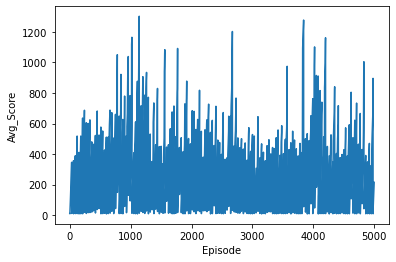

In [37]:
plt.plot(score_list)
plt.ylabel('Avg_Score')
plt.xlabel('Episode')
plt.show()